## Accessing the ECDC COVID-19 Data

J. Colliander  
2020-03-24

> The goal of this notebook is to implement the ideas in [this Medium post](https://medium.com/@vilhelmp/get-covid-19-dataset-into-a-pandas-dataframe-bb5eb23097550) by Magnus Vilhelm Persson. The target is to effectively download the COVID-19 cases data (from the European Centre for Disease Control (ECDC)) by region (mostly countries), make this data available in the form of a Pandas DataFrame, and generate a first few visualizations. 

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns 
DATE = datetime.today()
DATE_STR = DATE.strftime('%Y-%m-%d')
BASE_URL = f'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-{DATE_STR}.xlsx'
print(f'Downloading for {DATE_STR}')
while True:
    try:
        BASE_URL = f'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-{DATE_STR}.xlsx'
        data_world = pd.read_excel(BASE_URL)
        print('Success!')
        break
    except:
        print(f'Couldn\’t get data for {DATE_STR}, trying a day before…')
        # subtract a day
        DATE = DATE - timedelta(days=1)
        DATE_STR = DATE.strftime('%Y-%m-%d')

Success!


In [2]:
# some preprocessing
# change column names
data_world.rename(columns={'DateRep':'datestr','Countries and territories':'country', 'Cases':'cases', 'Deaths':'deaths', 'GeoId':'geoid'},
inplace=True)# convert dates
data_world['date'] = pd.to_datetime(data_world.datestr, format= "%Y-%m-%d")# remove unnecessary columns 
data_world.drop('Day', axis=1, inplace=True)
data_world.drop('Month', axis=1, inplace=True)
data_world.drop('Year', axis=1, inplace=True)
data_world.drop('datestr', axis=1, inplace=True)# set date as index
data_world = data_world.set_index('date').sort_index()# calculate cases for the whole world
total = data_world.groupby('date').sum()
# add columns and add to full dataframe
total['geoid'] = 'W'
total['country'] = 'World'
#total['datestr'] = total.index.astype('str')
total.reset_index()
data_world = data_world.append(total, sort=False)# calculate cases for world outside China
total_outcn = data_world.query("geoid not in ['W', 'CN']").groupby('date').sum()
# add columns and add to full dataframe
total_outcn['geoid'] = 'OUTC'
total_outcn['country'] = 'OutsideC'
#total['datestr'] = total.index.astype('str')
total_outcn.reset_index()
data_world = data_world.append(total_outcn, sort=False)# calculate cumulative sum for each country
data_world['cases_cum'] = data_world.groupby(['country'])['cases'].cumsum()
data_world['deaths_cum'] = data_world.groupby(['country'])['deaths'].cumsum()

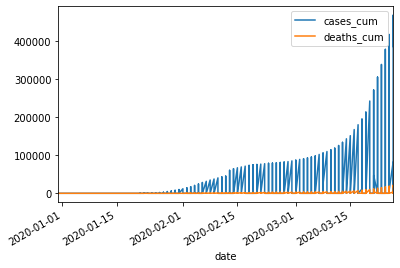

In [3]:
data_world[['cases_cum','deaths_cum']].plot()

Yay! I've implemented the Medium article. 2020-03-24, 9:26pm.

In [4]:
## Identify programs that have received the most funding
pd.pivot_table(data_world, index=['country'], aggfunc=max,
               values = ['cases_cum', 'deaths_cum']
              ).sort_values(by=['cases_cum'], ascending=False)

,cases_cum,deaths_cum
country,,
World,467710,20947
OutsideC,385742,17654
China,81968,3293
Italy,74386,7505
United_States_of_America,69194,1050
Spain,47610,3434
Germany,36508,198
Iran,27017,2077
France,25233,1331


## Focus on a single country

In [5]:
COUNTRY = 'Italy'

In [6]:
local = data_world.loc[(data_world['country'] == COUNTRY)]

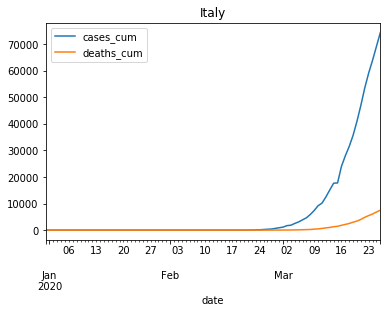

In [7]:
local[['cases_cum', 'deaths_cum']].plot(title = COUNTRY)

## Focus on a group of countries for comparison

In [8]:
Comparisons = ['Canada', 'United_States_of_America', 'France', 'Germany', 'South_Korea', 'China']

In [9]:
subset = data_world.loc[(data_world['country'].isin(Comparisons))]

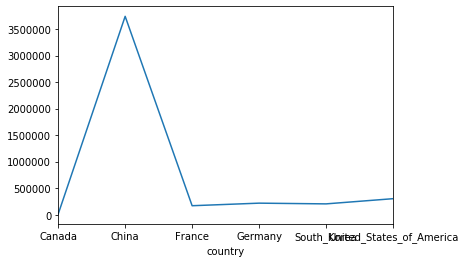

In [15]:
(subset.groupby(['country']).sum()['cases_cum']).plot()

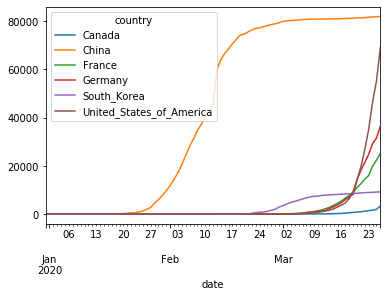

In [12]:
subset.pivot(columns="country", values="cases_cum").plot()